In [ ]:
**

In [1]:
# Cell 1 — installs (safe to re-run; skip if you already have these)
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].split(">=")[0].split("[")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in [
    "torch",
    "torchvision",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "Pillow",
]:
    pip_install(pkg)

print("✅ Environment ready")


✅ Environment ready


In [2]:
# Cell 2 — imports / constants
from pathlib import Path
import json, os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from collections import Counter


# EfficientNet + weights (torchvision >=0.13 has Weights enums)
from torchvision.models import (
    efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3,
    efficientnet_b4, efficientnet_b5, efficientnet_b6, efficientnet_b7,
)
try:
    from torchvision.models import (
        EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights,
        EfficientNet_B3_Weights, EfficientNet_B4_Weights, EfficientNet_B5_Weights,
        EfficientNet_B6_Weights, EfficientNet_B7_Weights,
    )
    WEIGHTS_AVAILABLE = True
except Exception:
    WEIGHTS_AVAILABLE = False

# >>>>> YOUR PATHS <<<<<
IMG_DIR  = Path("/Users/BalqisHebat/Downloads/s_1024")
CSV_PATH = Path("/Users/BalqisHebat/Downloads/streetSurfaceVis_v1_0_2.csv")

OUT_DIR = Path("./outputs_streetsurfacevis")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Device selection (CUDA if present, then Apple MPS, else CPU)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

DEVICE



device(type='mps')

In [3]:
# Cell 3 — read CSV and detect filename + master/subclass columns (robust)
import re

df = pd.read_csv(CSV_PATH)
print("CSV columns:", list(df.columns))
display(df.head())

# ===== OPTIONAL MANUAL OVERRIDES (set to strings if you know them) =====
FILENAME_COL_OVERRIDE = None   # e.g. "image_path" or "filename"
MASTER_COL_OVERRIDE   = None   # e.g. "surface_type"
SUB_COL_OVERRIDE      = None   # e.g. "damage_type"
# ======================================================================

# Build a case-insensitive lookup: lower_name -> actual_name
lower2actual = {c.lower(): c for c in df.columns}

def find_col(candidates):
    for alias in candidates:
        if alias.lower() in lower2actual:
            return lower2actual[alias.lower()]
    return None

# 1) Filename column
if FILENAME_COL_OVERRIDE:
    FILENAME_COL = FILENAME_COL_OVERRIDE
else:
    FILENAME_CANDIDATES = [
        "filepath","file_path","path","image_path","image","img","filename","file",
        "name","relative_path","relpath","full_path","abs_path","image_name","image_id"
    ]
    FILENAME_COL = find_col(FILENAME_CANDIDATES)

# 2) Master + Subclass columns (prefer explicit two columns)
if MASTER_COL_OVERRIDE:
    MASTER_COL = MASTER_COL_OVERRIDE
else:
    MASTER_CANDS = [
        "master","surface","surface_type","surface_class","coarse","coarse_label",
        "superclass","top_class","type","road_type","material","parent_class"
    ]
    MASTER_COL = find_col(MASTER_CANDS)

if SUB_COL_OVERRIDE:
    SUB_COL = SUB_COL_OVERRIDE
else:
    SUB_CANDS = [
        "subclass","sub","sub_type","subclass_label","fine","fine_label","subcategory",
        "damage","damage_type","condition","defect","pattern"
    ]
    SUB_COL = find_col(SUB_CANDS)

# 3) If we didn't find both, try to split a single combined label col (e.g., "label" or "class")
COMBINED_COL = None
if MASTER_COL is None or SUB_COL is None:
    COMBINED_CANDS = ["label","labels","class","classes","category","target","fine_label","master_sub"]
    COMBINED_COL = find_col(COMBINED_CANDS)

    if COMBINED_COL is not None:
        # Try to split with common delimiters: "/", " - ", ">", "|", ":", ";"
        def split_pair(s):
            if not isinstance(s, str):
                s = str(s)
            # first try "/", then others
            for pat in [r"/", r"\s*-\s*", r"\s*>\s*", r"\|", r":", r";"]:
                parts = re.split(pat, s, maxsplit=1)
                if len(parts) == 2:
                    return parts[0].strip(), parts[1].strip()
            return s.strip(), None  # couldn't split

        m_vals, s_vals = [], []
        for v in df[COMBINED_COL].astype(str).fillna(""):
            m, s = split_pair(v)
            m_vals.append(m)
            s_vals.append(s)
        df["__master_tmp"] = m_vals
        df["__sub_tmp"]    = s_vals

        # If many subs are None, assume only master provided
        if pd.Series(s_vals).notna().mean() < 0.5:
            SUB_COL = None
        else:
            SUB_COL = "__sub_tmp"
        MASTER_COL = "__master_tmp"

# 4) Final checks
if FILENAME_COL is None:
    raise ValueError(
        "Could not detect a filename column. Set FILENAME_COL_OVERRIDE to the correct column name."
    )
if MASTER_COL is None:
    raise ValueError(
        "Could not detect a master-class column. Set MASTER_COL_OVERRIDE or provide a combined label column I can split."
    )

# If subclass truly missing, we’ll proceed with master only; otherwise we have both.
print(f"Detected filename column: {FILENAME_COL!r}")
print(f"Detected master column:   {MASTER_COL!r}")
print(f"Detected subclass column: {SUB_COL!r}")

# Basic stats
print("\nMaster label counts:")
display(df[MASTER_COL].value_counts().to_frame("count"))

if SUB_COL is not None:
    print("\nSubclass label counts (top 20):")
    display(df[SUB_COL].value_counts().head(20).to_frame("count"))

# Keep these vars for later cells
FILENAME_COL = FILENAME_COL
MASTER_COL   = MASTER_COL
SUB_COL      = SUB_COL


CSV columns: ['mapillary_image_id', 'path', 'filepath', 'user_id', 'user_name', 'captured_at', 'longitude', 'latitude', 'train', 'type', 'surface_quality']


,mapillary_image_id,path,filepath,user_id,user_name,captured_at,longitude,latitude,train,type,surface_quality
0,1000927687276860,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10009276872...,103606985215406,dsmm,1655735677353,13.287805,51.502597,True,concrete,intermediate
1,1001349260556407,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10013492605...,102468835332129,ber319,1659015876793,14.426536,52.217757,True,unpaved,bad
2,1001419624308587,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10014196243...,100232345559807,carlheinz,1698249177500,13.457938,52.512914,True,asphalt,good
3,1001712924422413,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10017129244...,100232345559807,carlheinz,1699107239000,13.386874,52.564970,True,concrete,excellent
4,1001853784055707,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10018537840...,102627028648372,kartonage,1652268883000,13.389880,52.546260,True,asphalt,excellent


Detected filename column: 'filepath'
Detected master column:   'type'
Detected subclass column: None

Master label counts:


,count
type,
asphalt,3734
paving_stones,2037
sett,1363
unpaved,1016
concrete,972


In [4]:
# Cell 4 — index image files for robust resolution
from tqdm import tqdm

def index_images(root: Path):
    idx = {}
    # You can restrict extensions if needed
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    for p in tqdm(list(root.rglob("*")), desc=f"Indexing {root}"):
        if p.is_file() and p.suffix.lower() in exts:
            idx.setdefault(p.name, []).append(p)
    return idx

basename_index = index_images(IMG_DIR)
print(f"Indexed {sum(len(v) for v in basename_index.values())} images. "
      f"Unique basenames: {len(basename_index)}")


Indexing /Users/BalqisHebat/Downloads/s_1024: 100%|██████████████████████████████████████████████████████████████████████████████████| 9122/9122 [00:00<00:00, 282256.56it/s]

Indexed 9122 images. Unique basenames: 9122


In [5]:
# Cell 5 — resolve paths
def resolve_path(row):
    raw = str(row[FILENAME_COL]).strip()
    candidate = IMG_DIR / raw
    if candidate.exists():
        return candidate
    # Fallback: try basename search
    base = os.path.basename(raw)
    hits = basename_index.get(base, [])
    if len(hits) == 1:
        return hits[0]
    elif len(hits) > 1:
        # If duplicates, prefer the one with longest common suffix match
        # (you can customize; for now pick the first deterministically)
        return sorted(hits, key=lambda p: len(str(p)))[0]
    return None

df["resolved_path"] = df.apply(resolve_path, axis=1)
missing = df["resolved_path"].isna().sum()
print(f"Unresolved rows: {missing}")

# Drop rows without files
df = df.dropna(subset=["resolved_path"]).reset_index(drop=True)
print(f"Usable rows after drop: {len(df)}")



Unresolved rows: 0
Usable rows after drop: 9122


In [6]:
# Cell 6 — encode *fine* labels (auto-detect SUB_COL if needed)
from collections import Counter

if MASTER_COL is None:
    raise ValueError(
        "MASTER_COL is None. Go back to Cell 3 and set MASTER_COL_OVERRIDE to your master label column."
    )

# Try to auto-detect SUB_COL if missing
if SUB_COL is None:
    print("[info] SUB_COL is None — attempting to auto-detect subclass column...")

    # 1) Try by common subclass-ish names
    SUB_NAME_HINTS = [
        "subclass","sub","sub_type","subclass_label","fine","fine_label",
        "subcategory","damage","damage_type","condition","defect","pattern",
        "severity","level","class2","subcat","child","detail"
    ]
    lower2actual = {c.lower(): c for c in df.columns}
    for k in SUB_NAME_HINTS:
        if k.lower() in lower2actual and lower2actual[k.lower()] != MASTER_COL:
            SUB_COL = lower2actual[k.lower()]
            print(f"[auto] Using subclass column by name: {SUB_COL!r}")
            break

    # 2) If still not found, try by cardinality (prefer 5 unique values)
    if SUB_COL is None:
        candidates = []
        for c in df.columns:
            if c in {FILENAME_COL, MASTER_COL}:
                continue
            nun = df[c].nunique(dropna=True)
            # look for small categorical columns
            if 2 <= nun <= 10:
                candidates.append((c, nun))
        # Prefer nunique closest to 5, then smaller nunique
        candidates.sort(key=lambda x: (abs(x[1] - 5), x[1]))
        if candidates:
            SUB_COL = candidates[0][0]
            print(f"[auto] Using subclass column by cardinality: {SUB_COL!r} (unique={df[SUB_COL].nunique()})")

    if SUB_COL is None:
        raise ValueError(
            "Could not determine SUB_COL automatically. "
            "Set SUB_COL_OVERRIDE in Cell 3 to your subclass column and re-run."
        )

# Sanity stats for master/sub
print("Master unique:", df[MASTER_COL].nunique(), "| Subclass unique:", df[SUB_COL].nunique())
print("Master counts:")
display(df[MASTER_COL].value_counts().to_frame("count").head(10))
print("Subclass counts:")
display(df[SUB_COL].value_counts().to_frame("count").head(10))

# Build a combined fine label (e.g., 'asphalt/crack')
df["fine_label"] = df[MASTER_COL].astype(str).fillna("UNK") + "/" + df[SUB_COL].astype(str).fillna("UNK")

# Classes & mappings
classes = sorted(df["fine_label"].unique())
cls_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_cls = {i: c for i, c in enumerate(classes)}

df["label_idx"] = df["fine_label"].map(cls_to_idx)

# Save mapping
(OUT_DIR / "classes_fine.json").write_text(json.dumps(idx_to_cls, indent=2))
print(f"Num fine classes: {len(classes)}  (expect ~25 if 5x5)")
print("Saved mapping to:", OUT_DIR / "classes_fine.json")


[info] SUB_COL is None — attempting to auto-detect subclass column...
[auto] Using subclass column by cardinality: 'surface_quality' (unique=5)
Master unique: 5 | Subclass unique: 5
Master counts:


,count
type,
asphalt,3734
paving_stones,2037
sett,1363
unpaved,1016
concrete,972


Subclass counts:


,count
surface_quality,
good,3238
intermediate,2610
excellent,1670
bad,1301
very_bad,303


Num fine classes: 18  (expect ~25 if 5x5)
Saved mapping to: outputs_streetsurfacevis/classes_fine.json


In [7]:
# Cell 7 — stratified split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_idx"]
)
print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("Train distribution:", Counter(train_df["label_idx"]))
print("Val distribution:", Counter(val_df["label_idx"]))


Train: 7297 | Val: 1825
Train distribution: Counter({2: 1357, 10: 850, 1: 777, 3: 657, 14: 555, 12: 432, 11: 415, 15: 310, 9: 308, 6: 280, 16: 261, 5: 251, 17: 242, 7: 200, 0: 197, 13: 103, 8: 56, 4: 46})
Val distribution: Counter({2: 339, 10: 213, 1: 194, 3: 164, 14: 139, 12: 108, 11: 104, 15: 77, 9: 77, 6: 70, 16: 65, 5: 63, 17: 61, 7: 50, 0: 49, 13: 26, 8: 14, 4: 12})


In [8]:
# Cell 8 — custom Dataset
class CSVDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform=None):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        img_path = Path(row["resolved_path"])
        img = Image.open(img_path).convert("RGB")
        label = int(row["label_idx"])
        if self.transform:
            img = self.transform(img)
        return img, label


In [9]:
# Cell 9 — model factory + transforms
MODEL_NAME = "efficientnet_b0"   # change to b1..b7 if you like
USE_PRETRAINED = True            # set False to train from scratch

MODEL_FNS = {
    "efficientnet_b0": efficientnet_b0,
    "efficientnet_b1": efficientnet_b1,
    "efficientnet_b2": efficientnet_b2,
    "efficientnet_b3": efficientnet_b3,
    "efficientnet_b4": efficientnet_b4,
    "efficientnet_b5": efficientnet_b5,
    "efficientnet_b6": efficientnet_b6,
    "efficientnet_b7": efficientnet_b7,
}

WEIGHTS_ENUM = {
    "efficientnet_b0": EfficientNet_B0_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b1": EfficientNet_B1_Weights.IMAGENET1K_V2 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b2": EfficientNet_B2_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b3": EfficientNet_B3_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b4": EfficientNet_B4_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b5": EfficientNet_B5_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b6": EfficientNet_B6_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b7": EfficientNet_B7_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
}

weights = WEIGHTS_ENUM.get(MODEL_NAME, None) if USE_PRETRAINED else None
if weights is not None:
    train_transform = weights.transforms()
    val_transform   = weights.transforms()
else:
    # reasonable defaults if weights not available
    train_transform = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ])
    val_transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ])

train_ds = CSVDataset(train_df, transform=train_transform)
val_ds   = CSVDataset(val_df,   transform=val_transform)

# Note: on macOS in notebooks, num_workers=0 avoids multiprocessing issues
BATCH_SIZE   = 32
NUM_WORKERS  = 0

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

len(train_ds), len(val_ds)


(7297, 1825)

In [10]:
# Cell 10 — model init
NUM_CLASSES = len(classes)
model = MODEL_FNS[MODEL_NAME](weights=weights)

# Replace classifier (EfficientNet uses classifier[-1] linear)
if hasattr(model, "classifier"):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
else:
    # Fallback if API changes
    last_linear = None
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Linear):
            last_linear = (name, module)
            break
    parent = model
    *path, attr = last_linear[0].split(".")
    for p in path:
        parent = getattr(parent, p)
    setattr(parent, attr, nn.Linear(last_linear[1].in_features, NUM_CLASSES))

model = model.to(DEVICE)
                                                    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

best_acc = 0.0
BEST_PATH = OUT_DIR / f"{MODEL_NAME}_best.pth"

print(f"Model: {MODEL_NAME} | Classes: {NUM_CLASSES} | Device: {DEVICE}")


Model: efficientnet_b0 | Classes: 18 | Device: mps


/var/folders/r7/ptrtdl_s5_l4vw1lm6350js80000gn/T/ipykernel_26594/613789371.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))


In [11]:
# Cell 11 — train / eval helpers
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / max(1, total)

def train_one_epoch(model, loader, optimizer, scaler, device, criterion):
    model.train()
    running = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item() * labels.size(0)
    return running / max(1, len(loader.dataset))


In [12]:
# Cell 12 — train run
EPOCHS = 5

for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, scaler, DEVICE, criterion)
    val_acc = evaluate(model, val_loader, DEVICE)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            "model": model.state_dict(),
            "classes": idx_to_cls,
            "model_name": MODEL_NAME
        }, BEST_PATH)
    print(f"Epoch {epoch:03d}/{EPOCHS} | train_loss={tr_loss:.4f} | val_acc={val_acc:.4f}"
          + ("  <-- best" if val_acc == best_acc else ""))

print(f"✅ Done. Best val_acc={best_acc:.4f}. Saved: {BEST_PATH}")


/var/folders/r7/ptrtdl_s5_l4vw1lm6350js80000gn/T/ipykernel_26594/2518056056.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 001/5 | train_loss=1.5667 | val_acc=0.5458  <-- best
Epoch 002/5 | train_loss=1.0230 | val_acc=0.5403
Epoch 003/5 | train_loss=0.7703 | val_acc=0.5879  <-- best
Epoch 004/5 | train_loss=0.5817 | val_acc=0.5370
Epoch 005/5 | train_loss=0.4148 | val_acc=0.5649
✅ Done. Best val_acc=0.5879. Saved: outputs_streetsurfacevis/efficientnet_b0_best.pth


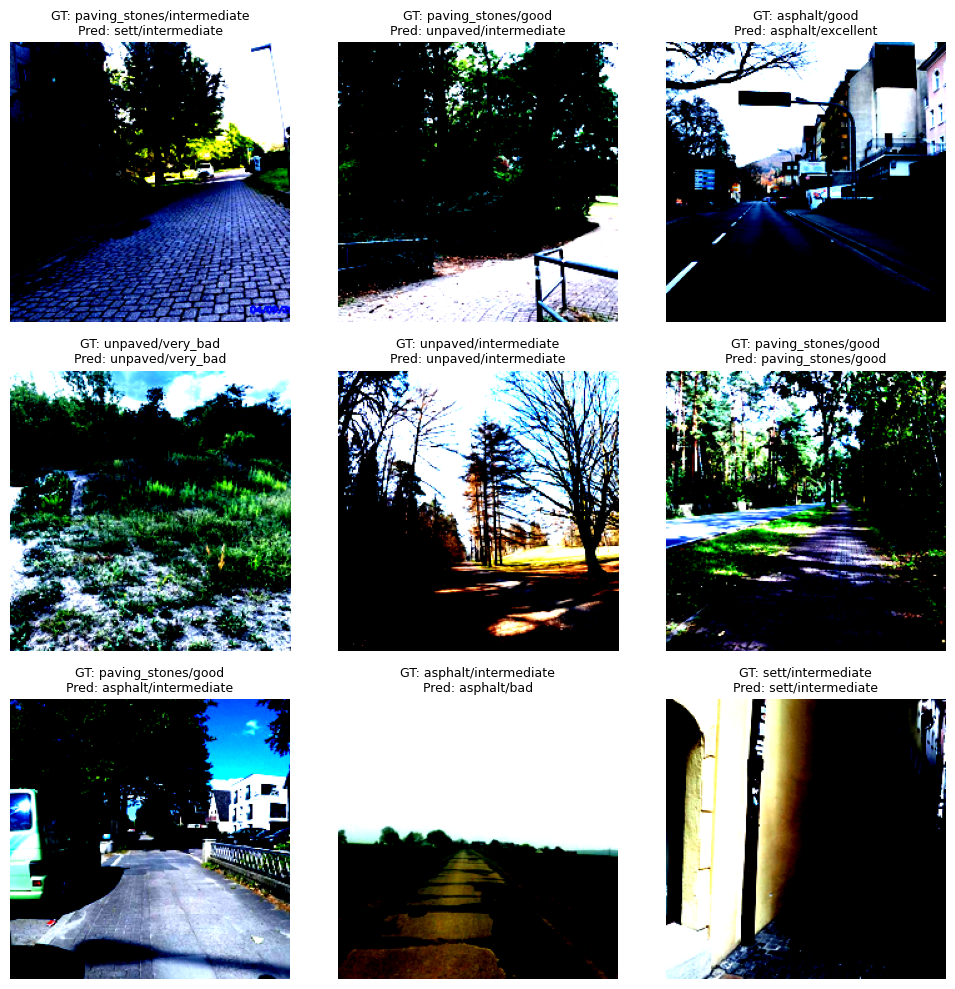

In [13]:
# Cell 13 — visualize predictions with master/subclass
import matplotlib.pyplot as plt
import numpy as np

model.eval()
imgs, labels = next(iter(val_loader))
with torch.no_grad():
    logits = model(imgs.to(DEVICE))
    preds = logits.argmax(1).cpu().numpy()

plt.figure(figsize=(10, 10))
n = min(9, len(imgs))
for i in range(n):
    ax = plt.subplot(3, 3, i+1)
    im = imgs[i].permute(1,2,0).numpy()
    im = np.clip(im, 0, 1)
    plt.imshow(im)

    gt_fine = idx_to_cls[int(labels[i].item())]
    pr_fine = idx_to_cls[int(preds[i])]
    gt_master, gt_sub = gt_fine.split("/", 1)
    pr_master, pr_sub = pr_fine.split("/", 1)

    ax.set_title(f"GT: {gt_master}/{gt_sub}\nPred: {pr_master}/{pr_sub}", fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [14]:
# Extra cell — fine vs coarse accuracy
@torch.no_grad()
def coarse_fine_accuracy(model, loader, device):
    model.eval()
    fine_correct = fine_total = 0
    coarse_correct = coarse_total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        labels_np = labels.numpy()

        # Fine accuracy
        fine_correct += (preds == labels_np).sum()
        fine_total   += len(labels_np)

        # Coarse accuracy: compare master parts only
        pred_master  = [idx_to_cls[int(p)].split("/", 1)[0] for p in preds]
        label_master = [idx_to_cls[int(t)].split("/", 1)[0] for t in labels_np]
        coarse_correct += sum(pm == lm for pm, lm in zip(pred_master, label_master))
        coarse_total   += len(labels_np)

    return fine_correct / max(1, fine_total), coarse_correct / max(1, coarse_total)

fine_acc, coarse_acc = coarse_fine_accuracy(model, val_loader, DEVICE)
print(f"Fine (25-class) acc:   {fine_acc:.4f}")
print(f"Coarse (5-class) acc:  {coarse_acc:.4f}")


Fine (25-class) acc:   0.5649
Coarse (5-class) acc:  0.8855


In [15]:
from PIL import Image, ImageOps
from pathlib import Path

# Pick any image path:
# 1) from your dataframe (recommended)
p = Path(df.loc[0, "resolved_path"]) if "resolved_path" in df.columns else None

# 2) or hardcode a path if needed:
# p = Path("/Users/BalqisHebat/Downloads/s_1024/some_image.jpg")

assert p is not None and p.exists(), f"Image not found: {p}"

with Image.open(p) as im:
    w, h = im.size  # stored size (no EXIF transpose)
    w2, h2 = ImageOps.exif_transpose(im).size  # display size after applying EXIF orientation
    print(f"Stored size:  {w} x {h}")
    print(f"Display size: {w2} x {h2}  (after EXIF)")
    print(f"Format: {im.format}  Mode: {im.mode}")


Stored size:  1024 x 576
Display size: 1024 x 576  (after EXIF)
Format: JPEG  Mode: RGB
